<a href="https://colab.research.google.com/github/probml/pyprobml/blob/master/book1/mlp/tfds_intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to tensorflow datasets

[TFDS](https://www.tensorflow.org/datasets) is a handy way to handle large datasets as a stream of minibatches, suitable for large scale training and parallel evaluation. It can be used by tensorflow and JAX code, as we illustrate below. (See the [official colab](https://colab.research.google.com/github/tensorflow/datasets/blob/master/docs/overview.ipynb) for details.)




In [2]:
# Standard Python libraries
from __future__ import absolute_import, division, print_function, unicode_literals

from typing import Any, Iterator, Mapping, NamedTuple, Sequence, Tuple

import os
import time
import numpy as np
import glob
import matplotlib.pyplot as plt
import PIL
import imageio
from IPython import display
import sklearn


In [8]:

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"
import tensorflow_datasets as tfds

print("tf version {}".format(tf.__version__))


tf version 2.4.0


In [4]:
import jax
from typing import Any, Callable, Sequence, Optional, Dict, Tuple
import jax.numpy as jnp

rng = jax.random.PRNGKey(0)

In [6]:
# Useful type aliases

Array = jnp.ndarray
PRNGKey = Array
Batch = Mapping[str, np.ndarray]
OptState = Any


# Manipulating data without using TFDS

We first illustrate how to make streams of minibatches using vanilla numpy code. TFDS will then let us eliminate a lot of this boilerplate. As an example, let's package some small labeled datasets into two dictionaries, for train and test.

In [ ]:
import sklearn
import sklearn.datasets
from sklearn.model_selection import train_test_split

def get_datasets_iris():
  iris = sklearn.datasets.load_iris()
  X = iris["data"]
  y = iris["target"] 
  N, D = X.shape # 150, 4
  X_train, X_test, y_train, y_test = train_test_split(
          X, y, test_size=0.33, random_state=42)
  train_ds = {'X': X_train, 'y': y_train}
  test_ds = {'X': X_test, 'y': y_test}
  return train_ds, test_ds

train_ds, test_ds = get_datasets_iris()
print(train_ds['X'].shape)
print(train_ds['y'].shape)

(100, 4)
(100,)


In [ ]:
iris = sklearn.datasets.load_iris()
print(iris.feature_names)
print(iris.target_names)

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
['setosa' 'versicolor' 'virginica']


Now we make one pass (epoch) over the data, computing random minibatches of size 30. There are 100 examples total, but with a batch size of 30,
we don't use all the data. We can solve such "boundary effects" later. 

In [ ]:
def extract_batch(ds, ndx):
  batch = {k: v[ndx, ...] for k, v in ds.items()}
  #batch = {'X': ds['X'][ndx,:],  'y': ds['y'][ndx]}
  return batch

def process_epoch(train_ds, batch_size, rng):
  train_ds_size = len(train_ds['X'])
  steps_per_epoch = train_ds_size // batch_size
  perms = jax.random.permutation(rng, len(train_ds['X']))
  perms = perms[:steps_per_epoch * batch_size]  # skip incomplete batch
  perms = perms.reshape((steps_per_epoch, batch_size)) # perms[i,:] is list of  data indices for step i
  for step, perm in enumerate(perms):
    batch = extract_batch(train_ds, perm)
    print('processing batch {} X shape {}, y shape {}'.format(
        step, batch['X'].shape, batch['y'].shape))

batch_size = 30
process_epoch(train_ds, batch_size, rng)


processing batch 0 X shape (30, 4), y shape (30,)
processing batch 1 X shape (30, 4), y shape (30,)
processing batch 2 X shape (30, 4), y shape (30,)


# Using TFDS

In [ ]:


def load_dataset_iris(split: str, batch_size: int) -> Iterator[Batch]:
  train_ds, test_ds = get_datasets_iris()
  if split == tfds.Split.TRAIN:
    ds = tf.data.Dataset.from_tensor_slices({"X": train_ds["X"], "y": train_ds["y"]})
  elif split == tfds.Split.TEST:
    ds = tf.data.Dataset.from_tensor_slices({"X": test_ds["X"], "y": test_ds["y"]})
  ds = ds.shuffle(buffer_size=1 * batch_size)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=5)
  ds = ds.repeat() # make infinite stream of epochs
  return iter(tfds.as_numpy(ds)) # python iterator

batch_size = 30
train_ds = load_dataset_iris(tfds.Split.TRAIN, batch_size)
valid_ds = load_dataset_iris(tfds.Split.TEST, batch_size)

print(train_ds)

training_steps = 5
for step in range(training_steps):
  batch = next(train_ds)
  print('processing batch {} X shape {}, y shape {}'.format(
        step, batch['X'].shape, batch['y'].shape))

<generator object _eager_dataset_iterator at 0x7fdf48ff1728>
processing batch 0 X shape (30, 4), y shape (30,)
processing batch 1 X shape (30, 4), y shape (30,)
processing batch 2 X shape (30, 4), y shape (30,)
processing batch 3 X shape (10, 4), y shape (10,)
processing batch 4 X shape (30, 4), y shape (30,)


# Using pre-packaged datasets

There are many standard datasets available from https://www.tensorflow.org/datasets. We give some examples below.


In [ ]:
ds, info = tfds.load("binarized_mnist", split=tfds.Split.TRAIN, shuffle_files=True, with_info=True)
print(ds)
print(info)

<_OptionsDataset shapes: {image: (28, 28, 1)}, types: {image: tf.uint8}>
tfds.core.DatasetInfo(
    name='binarized_mnist',
    version=1.0.0,
    description='A specific binarization of the MNIST images originally used in
(Salakhutdinov & Murray, 2008). This dataset is frequently used to evaluate
generative models of images, so labels are not provided.',
    homepage='http://www.dmi.usherb.ca/~larocheh/mlpython/_modules/datasets/binarized_mnist.html',
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
    }),
    total_num_examples=70000,
    splits={
        'test': 10000,
        'train': 50000,
        'validation': 10000,
    },
    supervised_keys=None,
    citation="""@inproceedings{salakhutdinov2008quantitative,
    title={On the quantitative analysis of deep belief networks},
    author={Salakhutdinov, Ruslan and Murray, Iain},
    booktitle={Proceedings of the 25th international conference on Machine learning},
    pages={872--879},
    yea

In [ ]:
train_ds, info = tfds.load("mnist", split=tfds.Split.TRAIN, shuffle_files=True, with_info=True)
print(train_ds)
print(info)

<_OptionsDataset shapes: {image: (28, 28, 1), label: ()}, types: {image: tf.uint8, label: tf.int64}>
tfds.core.DatasetInfo(
    name='mnist',
    version=3.0.1,
    description='The MNIST database of handwritten digits.',
    homepage='http://yann.lecun.com/exdb/mnist/',
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=70000,
    splits={
        'test': 10000,
        'train': 60000,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
    redistribution_info=,
)



In [9]:
ds = tfds.load('mnist', split='train')
print(type(ds))
ds = ds.take(1)  # Only take a single example
print(type(ds))

for example in ds:  # example is `{'image': tf.Tensor, 'label': tf.Tensor}`
  print(list(example.keys()))
  image = example["image"]
  label = example["label"]
  print(image.shape, label)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.





Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.
<class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>
<class 'tensorflow.python.data.ops.dataset_ops.TakeDataset'>
['image', 'label']
(28, 28, 1) tf.Tensor(4, shape=(), dtype=int64)


In [12]:
def rename(batch):
  d = {'inputs': batch['image'], 'outputs': batch['label']}
  return d

ds = tfds.load('mnist', split='train')
ds = ds.map(rename)
i = 0
for d in ds:
  print(d['inputs'].shape)
  i += 1
  if i>2: break

(28, 28, 1)
(28, 28, 1)
(28, 28, 1)


# Streams and iterators

In [ ]:
ds=tfds.as_numpy(train_ds)
print(ds)
for i, batch in enumerate(ds):
  print(type(batch))
  X = batch['image']
  y = batch['label']
  print(X.shape)
  print(y.shape)
  i += 1
  if i > 2: break

<class 'dict'>
(28, 28, 1)
()
<class 'dict'>
(28, 28, 1)
()
<class 'dict'>
(28, 28, 1)
()


In [ ]:
ds = tfds.load('mnist', split='train')
ds = ds.take(100)
#ds = tfds.as_numpy(ds)

batches = ds.repeat(2).batch(batch_size)
print(type(batches))
print(batches)

batch_stream = batches.as_numpy_iterator()
print(type(batch_stream))
print(batch_stream)

b = next(batch_stream)
print(type(b))
print(b['image'].shape)

b = batch_stream.next()
print(type(b))
print(b['image'].shape)

<class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>
<BatchDataset shapes: {image: (None, 28, 28, 1), label: (None,)}, types: {image: tf.uint8, label: tf.int64}>
<class 'tensorflow.python.data.ops.dataset_ops._NumpyIterator'>
<class 'dict'>
(30, 28, 28, 1)
<class 'dict'>
(30, 28, 28, 1)


In [ ]:
ds = tfds.load('mnist', split='train')
batches = ds.repeat().batch(batch_size)
batch_stream = batches.as_numpy_iterator()


def process_stream(stream):
  b = next(stream)
  X = b['image']
  y = b['label']
  d = {'X': X, 'y': y}
  yield d
  
my_stream = process_stream(batch_stream)

b = next(my_stream)
print(type(b))
print(b['X'].shape)

b = my_stream.next()
print(type(b))
print(b['X'].shape)



<class 'dict'>
(30, 28, 28, 1)


AttributeError: ignored

# Worked example

For efficiently processing datastreams, see [this webpage](https://www.tensorflow.org/datasets/performances).

In [ ]:
def load_dataset_mnist(split: tfds.Split, batch_size: int) -> Iterator[Batch]:
  ds, ds_info = tfds.load("mnist", split=split, with_info=True)
  # For true randomness, we set the shuffle buffer to the full dataset size.
  ds = ds.shuffle(ds_info.splits[split].num_examples)
  #ds = ds.shuffle(buffer_size=10 * batch_size)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
  ds = ds.repeat()
  return iter(tfds.as_numpy(ds))

def preprocess_batch(batch: Batch, prng_key = None) -> Batch:
  # Convert to X,y field names, optionally dequantize X, and convert to float
  X = batch['image'].astype(np.float32)
  y = batch['label']
  if prng_key is not None:
    # Dequantize pixel values {0, 1, ..., 255} with uniform noise [0, 1).
    X += jax.random.uniform(prng_key, X.shape)
  X = X / 256.  # Normalize pixel values from [0, 256) to [0, 1)
  d = {'X': X, 'y': y}
  return d

batch_size = 30
train_ds = load_dataset_mnist(tfds.Split.TRAIN, batch_size)
print(type(train_ds))

training_steps = 5
for step in range(training_steps):
  batch = next(train_ds)
  batch = preprocess_batch(batch, rng)
  X = batch['X']; y = batch['y']
  print('processing batch {} X shape {}, y shape {}'.format(
        step, X.shape, y.shape))

<class 'generator'>
processing batch 0 X shape (30, 28, 28, 1), y shape (30,)
processing batch 1 X shape (30, 28, 28, 1), y shape (30,)
processing batch 2 X shape (30, 28, 28, 1), y shape (30,)
processing batch 3 X shape (30, 28, 28, 1), y shape (30,)
processing batch 4 X shape (30, 28, 28, 1), y shape (30,)


# Data visualization

In [ ]:

import pandas as pd
pd.set_option('precision', 2) # 2 decimal places
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 30)
pd.set_option('display.width', 100) # wide windows

#ds, info = tfds.load('mnist', split='train', with_info=True)
ds, info = tfds.load('iris', split='train', with_info=True)
print(info)

df = tfds.as_dataframe(ds.take(4), info)
print(type(df))
print(df)

df.head()

Shuffling and writing examples to /root/tensorflow_datasets/iris/2.0.0.incompleteO65KB6/iris-train.tfrecord


Dataset iris downloaded and prepared to /root/tensorflow_datasets/iris/2.0.0. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='iris',
    version=2.0.0,
    description='This is perhaps the best known database to be found in the pattern recognition
literature. Fisher's paper is a classic in the field and is referenced
frequently to this day. (See Duda & Hart, for example.) The data set contains
3 classes of 50 instances each, where each class refers to a type of iris
plant. One class is linearly separable from the other 2; the latter are NOT
linearly separable from each other.',
    homepage='https://archive.ics.uci.edu/ml/datasets/iris',
    features=FeaturesDict({
        'features': Tensor(shape=(4,), dtype=tf.float32),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=3),
    }),
    total_num_examples=150,
    splits={
        'train': 150,
    },
    supervised_keys=('features', 'label'),
    citation="""@misc{Dua:2019 ,
    author = "Dua, D

,features,label
0,"[5.1, 3.4, 1.5, 0.2]",0
1,"[7.7, 3.0, 6.1, 2.3]",2
2,"[5.7, 2.8, 4.5, 1.3]",1
3,"[6.8, 3.2, 5.9, 2.3]",2


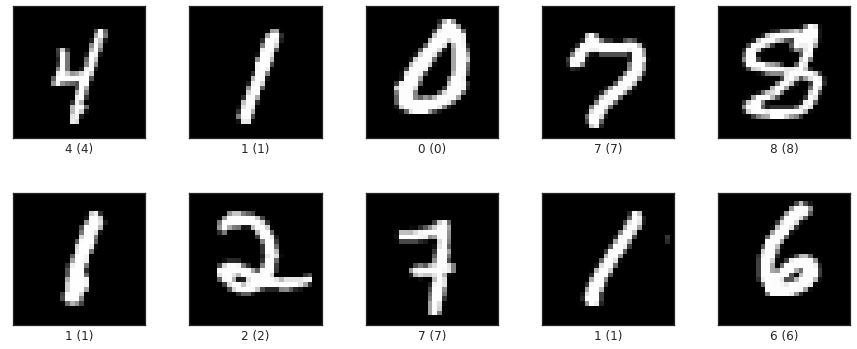

In [ ]:
ds, info = tfds.load('mnist', split='train', with_info=True)
fig = tfds.show_examples(ds, info, rows=2, cols=5)

# This function is not well documented. But source code for show_examples is here:
# https://github.com/tensorflow/datasets/blob/v4.2.0/tensorflow_datasets/core/visualization/image_visualizer.py

Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incompleteM2APQM/cifar10-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incompleteM2APQM/cifar10-test.tfrecord


Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


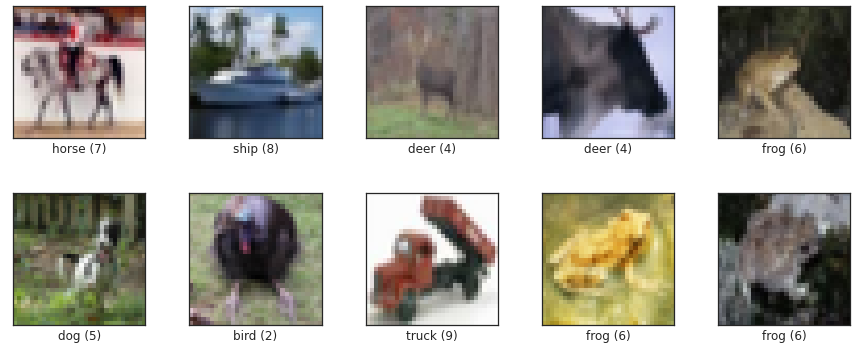

In [ ]:
ds, info = tfds.load('cifar10', split='train', with_info=True)
fig = tfds.show_examples(ds, info, rows=2, cols=5)

In [ ]:
import tensorflow_data_validation 
tfds.show_statistics(info)

ModuleNotFoundError: ignored

# Graveyard

Here we store some code we don't need (for now).

In [ ]:
def get_datasets_mnist():
  ds_builder = tfds.builder('mnist')
  ds_builder.download_and_prepare()
  train_ds_all = tfds.as_numpy(ds_builder.as_dataset(split='train', batch_size=-1))
  test_ds_all = tfds.as_numpy(ds_builder.as_dataset(split='test', batch_size=-1))

  num_train = len(train_ds_all['image'])
  train_ds['X'] = jnp.reshape(jnp.float32(train_ds_all['image']) / 255., (num_train, -1))
  train_ds['y'] = train_ds_all['label']

  num_test = len(test_ds_all['image'])
  test_ds['X'] = jnp.reshape(jnp.float32(test_ds['image']) / 255., (num_test, -1))
  test_ds['y'] = test_ds_all['label']

  return train_ds, test_ds

In [ ]:
dataset = load_dataset_iris(tfds.Split.TRAIN, 30)
batches = dataset.repeat().batch(batch_size)

step = 0
num_minibatches = 5
for batch in batches:
    if step >= num_minibatches:
        break
    X, y = batch['image'], batch['label']
    print('processing batch {} X shape {}, y shape {}'.format(
        step, X.shape, y.shape))
    step = step + 1

processing batch 0 X shape (30, 28, 28, 1), y shape (30,)
processing batch 1 X shape (30, 28, 28, 1), y shape (30,)
processing batch 2 X shape (30, 28, 28, 1), y shape (30,)
processing batch 3 X shape (30, 28, 28, 1), y shape (30,)
processing batch 4 X shape (30, 28, 28, 1), y shape (30,)


In [ ]:
print('batchified version v2')
batch_stream = batches.as_numpy_iterator()
for step in range(num_minibatches):
  batch = batch_stream.next()
  X, y = batch['image'], batch['label'] # convert to canonical names
  print('processing batch {} X shape {}, y shape {}'.format(
        step, X.shape, y.shape))
  step = step + 1

batchified version v2
processing batch 0 X shape (30, 28, 28, 1), y shape (30,)
processing batch 1 X shape (30, 28, 28, 1), y shape (30,)
processing batch 2 X shape (30, 28, 28, 1), y shape (30,)
processing batch 3 X shape (30, 28, 28, 1), y shape (30,)
processing batch 4 X shape (30, 28, 28, 1), y shape (30,)


In [ ]:

def sample_categorical(N, C):
  p = (1/C)*np.ones(C);
  y = np.random.choice(C, size=N, p=p);
  return y

def get_datasets_rnd():
  Ntrain = 1000; Ntest = 1000; D = 5; C = 10;
  train_ds = {'X': np.random.randn(Ntrain, D), 'y': sample_categorical(Ntrain, C)}
  test_ds = {'X': np.random.randn(Ntest, D), 'y': sample_categorical(Ntest, C)}
  return train_ds, test_ds


def get_datasets_logreg(key):
  Ntrain = 1000; Ntest = 1000; D = 5; C = 10;
  W = jax.random.normal(key, (D,C))

  Xtrain = jax.random.normal(key, (Ntrain, D))
  logits = jnp.dot(Xtrain, W)
  ytrain = jax.random.categorical(key, logits)

  Xtest = jax.random.normal(key, (Ntest, D))
  logits = jnp.dot(Xtest, W)
  ytest = jax.random.categorical(key, logits)

  train_ds = {'X': Xtrain, 'y': ytrain}
  test_ds = {'X': Xtest, 'y': ytest}
  return train_ds, test_ds